In [1]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to hande undersampled data
# and how to write a simple iterative reconstruction algorithm with
# the acquisition model.
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of March 2019
# Author: Johannes Mayer
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.




In [8]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR
from sirf.Utilities import examples_data_path

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt

#%% GO TO MR FOLDER
os.chdir( examples_data_path('MR'))

Using matplotlib backend: Qt5Agg


### Undersampled Reconstruction
#### Goals of this notebook:

- Write a fully sampled reconstruction on your own.
- Obtain knowledge of how to deal with undersampled data.
- User SIRF and Gadgetron to perform a GRAPPA reconstruction.
- Implement an iterative parallel imaging SENSE reconstruction algorithm from scratch.


In [3]:
# This is just an auxiliary function
def norm_array( arr ):
    min_a = abs(arr).min()
    max_a = abs(arr).max()
    
    return (arr - min_a)/(max_a - min_a)
    

### Time to get warmed up again:
Since we deal with undersampled data in this last section, we need to compare it to a reference.
So we need to reconstruct the fully sampled dataset we encountered before.

This is an ideal opprotunity to test what we learned and employ the `pMR.FullSampledReconstructor` class from before.

### Programming Task: Fully sampled reconstruction

__Please write code that does the following:__
- create a variable called `full_acq_data` of type `pMR.AcquisitionData` from the file `ptb_resolutionphantom_fully_ismrmrd.h5`
- create a variable called `prep_full_data` and assign it the preprocessed data by calling the function `pMR.preprocess_acquisition_data` on our variable `full_acq_data`
- create a variable called `recon` of type `pMR.FullySampledReconstructor()`
- call the `set_input` method of `recon` on `prep_full_data` to assign our fully sampled dataset to our reconstructor
- call the `process()` method of `recon` without arguments. 
- create a variable called `fs_image` and assign it the output of the `get_output` method of `recon`

__Hint:__ if you call a function without arguments, don't forget the empty parenthesis.

#### Don't look at the solution before you tried! 


In [4]:
# YOUR CODE GOES HERE








In [5]:
# VALIDATION CELL
fs_image_array = fs_image.as_array()
fs_image_array = norm_array(fs_image_array)

fig = plt.figure()
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully sampled reconstruction')
ax.axis('off')

NameError: name 'fs_image' is not defined

In [6]:
# Solution Cell. Don't look if you didn't try!





























filename_full_file = 'ptb_resolutionphantom_fully_ismrmrd.h5'

full_acq_data = pMR.AcquisitionData(filename_full_file)
prep_full_data = pMR.preprocess_acquisition_data( full_acq_data )

recon = pMR.FullySampledReconstructor()
recon.set_input( prep_full_data )
recon.process()
fs_image = recon.get_output()

(-0.5, 255.5, 255.5, -0.5)

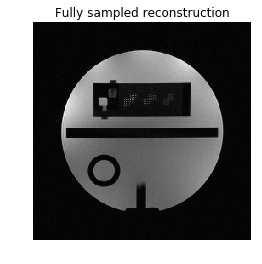

In [7]:
# VALIDATION CELL
fs_image_array = fs_image.as_array()
fs_image_array = norm_array(fs_image_array)

fig = plt.figure()
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully sampled reconstruction')
ax.axis('off')

In [9]:
# LOADING AND PREPROCESSING DATA FOR THIS SET
filename_grappa_file = 'ptb_resolutionphantom_GRAPPA4_ismrmrd.h5'
acq_data = pMR.AcquisitionData(filename_grappa_file)
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)
preprocessed_data.sort()


In [10]:
print('Is the data we loaded undersampled? %s' % preprocessed_data.is_undersampled())

Is the data we loaded undersampled? 1


In [11]:
#%% RETRIEVE K-SPACE DATA
k_array = preprocessed_data.as_array()
print('Size of k-space %dx%dx%d' % k_array.shape)

Size of k-space 112x4x256


In [12]:
#%% SELECT VIEW DATA FROM DIFFERENT COILS
print('Size of k-space %dx%dx%d' % k_array.shape)

num_channels = k_array.shape[1]
print(num_channels)
k_array = norm_array(k_array)


fig = plt.figure()
plt.set_cmap('gray')
for c in range(num_channels):
    ax = fig.add_subplot(2,num_channels/2,c+1)
    ax.imshow(abs(k_array[:,c,:]), vmin=0, vmax=0.05)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')


Size of k-space 112x4x256
4


This looks pretty similar to what we had before, so we should be good.

In [13]:
# we define a quick fft with sos coil combination to do a standard reconstruction.
def our_fft( k_array ):
    image_array = numpy.zeros(k_array.shape, numpy.complex128)
    for c in range(num_channels):
        image_array[:,c,:] = numpy.fft.fftshift( numpy.fft.ifft2( numpy.fft.ifftshift(k_array[:,c,:])))
#     image_array = image_array/image_array.max()    
    image_array = numpy.sqrt(numpy.sum(numpy.square(numpy.abs(image_array)),1))
     
    return image_array

In [14]:
# now we make a FFT of the data we looked at and compare it to our fully sampled image
image_array_sos = our_fft( k_array )
image_array_sos = norm_array(image_array_sos)


fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(image_array_sos), vmin=0, vmax=1)
ax.set_title('Undersampled')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully sampled')
ax.axis('off')


(-0.5, 255.5, 255.5, -0.5)

### Question: 
Please answer the following question for yourself:
 - Why is the undersampled reconstruction squeezed, but covers the whole FOV?


In [15]:
# NOW LET'S LOOK WHICH PARTS ARE SAMPLED AND WHICH ARE LEFT OUT
# kspace_encode_step_1 gives the phase encoding steps which were performed
which_pe = preprocessed_data.get_info('kspace_encode_step_1')


print( which_pe )

[0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92 96
 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 164 168 172 176 180 184 188 192 196
 200 204 208 212 216 220 224 228 232 236 240 244 248 252]


#### Observation: nearly every 4th phase encoding steps is missing.

In [16]:
# Fill an array with 1 only if a datapoint was acquired
sampling_mask = numpy.zeros([256,256])

for pe in which_pe:
    sampling_mask[pe,:] = 1

    

# PLOT THE SAMPLING MASK    
fig = plt.figure()
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( sampling_mask, vmin=0, vmax=1)
ax.set_title('Sampling pattern of a GRAPPA acquisition')
plt.xlabel('Frequency encoding')
plt.ylabel('Phase encoding')
#ax.axis('off')

Text(0, 0.5, 'Phase encoding')

We notice that $112 = \frac{256}{4} + 48$.
This means the around the center of k-space is densely sampled containing 48 readout lines.
The outside of k-space is undersampled by a factor of 4.

### Workaround: 'zero-fill' the k-space data
Since the artifacts seem to be related to the shape of the data, let's just change that shape into the one we want.  
But can we just add datapoints? This will corrupt the data!

Actually, a Fourier transform is just a sum weighted by a phase:

$$
f(x) = \sum_k e^{j k x} \cdot F(k)
$$

So it does not mind if we add a data point $F(k) = 0$ at a position we didn't sample!

This means we make a larger array, __add our data in the correct spots__, and the gaps we fill with zeros. The correct spots are given by our sampling mask!

In [17]:
k_shape = [sampling_mask.shape[0], num_channels, sampling_mask.shape[1]]
zf_k_array = numpy.zeros(k_shape, numpy.complex128)

for i in range(k_array.shape[0]):
    zf_k_array[which_pe[i],:,:] = k_array[i,:,:]


fig = plt.figure()
plt.set_cmap('gray')
for c in range(num_channels):
    ax = fig.add_subplot(2,num_channels/2,c+1)
    ax.imshow(abs(zf_k_array[:,c,:]), vmin=0, vmax=0.05)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
    
    
    

In [18]:
# Reconstruct the zero-filled data and take a look
zf_recon = our_fft( zf_k_array)
zf_recon = norm_array(zf_recon)


fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('Zero-filled Undersampled ')
ax.axis('off')


ax = fig.add_subplot(1,2,2)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully Sampled ')
ax.axis('off')


(-0.5, 255.5, 255.5, -0.5)

### Observation: 
Bummer. Now the shape is correct, however the artifacts are still present. 

 - What artifacts appear in the zero-filled reconstruction?
 - Why are they only fine-lined artifacts?
 - How come there are only duplications in one direction?

To get rid of these we will need some parallel imaging techniques.

### Coilsensitivity computation
Parallel imaging, this has something to do with exploiting the spatially varying coil sensitivities.  


In [19]:
# WHICH COILMAPS DO WE GET FROM THIS DATASET?
csm = pMR.CoilSensitivityData()
csm.smoothness = 40
csm.calculate(preprocessed_data, 'Inati()')
csm_array = numpy.squeeze(csm.as_array(0))

csm_array = csm_array.transpose([1,0,2])

fig = plt.figure()
plt.set_cmap('jet')
for c in range(csm_array.shape[1]):
    ax = fig.add_subplot(2,num_channels/2,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
plt.set_cmap('gray')

### Question: 
In practice we would want to use a weighted sum (WS) coil combination technique so any artifacts in the coilmap would directly translate into the combined image. But we didn't see any of the high frequency artifacts!

Please answer the following question:


- Why are there are artifacts in the reconstruction but not in the coilmaps? 


We learned before, that parallel imaging is easily able to get rid of undersampling factor R=4.
But to have enough information to estimate coilmaps the center must be fully sampled.  

Ergo a perfect acceleration by R=4 is not possible, one needs to spends some time to sample the center densely, to obtain coil sensitivities. Still, $\frac{112}{256} = 0.44$, we acquired 56% faster.

### GRAPPA Reconstruction
GRAPPA is a parallel imaging technique which promises to get rid of undersampling artifacts.  
So let's use one of our SIRF classes and see what it can do!

In [20]:
# WE DO A GRAPPA RECONSTRUCTION USING SIRF

recon = pMR.CartesianGRAPPAReconstructor()
recon.set_input(preprocessed_data)
recon.compute_gfactors(False)
print('---\n reconstructing...')

recon.process()
# for undersampled acquisition data GRAPPA computes Gfactor images
# in addition to reconstructed ones
grappa_images = recon.get_output()
grappa_images_array = grappa_images.as_array()
grappa_images_array = norm_array(grappa_images_array)

---
 reconstructing...


In [21]:
# PLOT THE RESULTS
fig = plt.figure()

ax = fig.add_subplot(1,3,1)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('Zero-filled Undersampled ')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(abs(grappa_images_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('GRAPPA')
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully Sampled')
ax.axis('off')

(-0.5, 255.5, 255.5, -0.5)

### Question:
Well, that was very little code to perform a difficult task! That is because we sent our data off to The Gadgetron and they did all the work.

In what respect did a GRAPPA reconstruction:

 * improve the resulting image?
 * deterioate the resulting image?


# GREAT! Now we want to develop our own algorithm and be better than the GRAPPA reconstruction!
## Urgh, let's rather not because we are so annoyed at how much code we have to write all the time!
### Enter: AcquisitionModel

We want to capture our entire imaging and reconstruction process in one single object and don't care about data structure. Also we don't want to have to sum over coil channels all the time and take care of zero filling, this is just too much work!  

In SIRF there exists something called AcquisitionModel, in the literature also referenced as and Encoding operator $E$, E for encoding.

In [22]:
# NOW WE GENERATE THE E OPERATOR FROM ABOVE AND ASSIGN OUR COIL SENSITIVITIES
E = pMR.AcquisitionModel(preprocessed_data, grappa_images)

From an image $x$, we want to be able to go __forward__ into k-space
$$ E: x \rightarrow y $$
implicitly performing multiplication of the image with the coil sensitivities $C_c$ for each channel $c$ and performing an FFT:

$$
E x = y_c = \mathcal{F}( C_c \cdot x) 
$$


From k-space data, we want to __backward__ into image space, doing the zero-filling, inverse FFT, and coil combination as one single operation:
$$ E^H: y \rightarrow x $$
, implicitly performing everything:  
$$
E^H y = x =  \frac{\sum_c C_c^*\mathcal{F}^{-1}(y) }{\sum_c C_c^*C_c}
$$

$E^H$ in this case is the hermitian conjugate of the complex valued operator $E$. It is the combination of transposing and complex conjugation of a matrix: $ E^H = (E^T)^*. For real matrices this reduces to just transposition.

In [23]:
help(E)

Help on AcquisitionModel in module sirf.Gadgetron object:

class AcquisitionModel(builtins.object)
 |  AcquisitionModel(acqs=None, imgs=None)
 |  
 |  Class for MR acquisition model, an operator that maps images into
 |  simulated acquisitions.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, acqs=None, imgs=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  backward(self, ad)
 |      Back-projects acquisition data into image space using a complex
 |      transpose of the forward projection.
 |      ad: AcquisitionData
 |  
 |  forward(self, image)
 |      Projects an image into (simulated) acquisitions space.
 |      The resulting acquisition data simulates the actual data
 |      expected to be received from the scanner.
 |      image: ImageData
 |  
 |  set_coil_sensitivity_maps(self, csm)
 |      Specifies the coil sensitivity maps to be used by the model.
 |      csm: CoilSensitivityData
 |  
 |  set_up(self, acqs, im

In [24]:
E.set_coil_sensitivity_maps(csm)

# Now we can hop back from k-space to image space in just one line:
aq_model_image = E.backward( preprocessed_data )
aq_model_image_array = aq_model_image.as_array()

Well this is not much code any more. Suddenly implementing our own iterative algorithm seems feasible!
### QUESTION
BEFORE YOU RUN THE NEXT CELL AND LOOK AT THE PLOT:
In the next plot the image stored in `aq_model_image_array` will be shown, i.e. $x = E^H y$.  
Based on the discussion what the AcquisitionModel E does, what do you expect the reconstruction to look like?
- Is it squeezed or is it the correct size?
- Does it contain artifacts? If so, which ones?

In [25]:
fig = plt.figure()
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(aq_model_image_array[0,:,:]))
ax.set_title('Result Backward Method of E ')
ax.axis('off')

(-0.5, 255.5, 255.5, -0.5)

__Well, bummer again, the artifacts are still there!__ Of course, the acquisition model is just a compact version of our above code. We need something smarter to kill them off. But it got a bit more homogeneous, due to the weighted coil combination. 

# Image Reconstruction as an Inverse Problem
## Iterative Parallel Imaging Reconstruction

In order to employ parallel imagaing, we should look at image reconstruction as an inverse problem.
By "image reconstruction" we actually mean to achieve the following equality:
$$ E x = y $$, or equivalently
$$ E^H E \, x = E^H y$$ 
where $E$ is the encoding operator $x$ is the true image object and $y$ is the MR raw data we acquired. 
The task of image reconstruction boils down to optimizing the following function:
$$ \mathcal{C}(x) = \frac{1}{2} \bigl{|} \bigl{|}  E^H E \, x - E^H y \bigr{|} \bigr{|}_2  \\
\tilde{x} = \min_x \mathcal{C}(x)
$$
To iteratively find the minimum of this cost function, $\tilde{x}$, we need to go through steps of the kind:
1. have a first guess for our image (usually an empty image)
2. generate k-space data from this guess and compute the discrepancy to our acquired data (i.e. evaluate the cost fuction).
3. update our image guess based on the computed discrepancy s.t. the cost will be lowered.  

__By iterating steps 2 and 3 many times we will end up at $\tilde{x}$.__

Is that going to be better than a GRAPPA reconstruction? 

## Implementing Conjugate Gradient Descent SENSE

Conjugate Gradient (CG) optimization is such an iterative procedure which will quickly result in finding $\tilde{x}$.
We can study the corresponding [Wikipedia Article](https://en.wikipedia.org/wiki/Conjugate_gradient_method#Description_of_the_problem_addressed_by_conjugate_gradients).

This looks like our thang! 

For that we need to write a bit of code:
- We already have this encoding operator `E` defined where we can go from image to k-space and back.
- Now we need to implement our first guess
- and somehow we loop through steps 2 and 3 updating our image s.t. the costs are lowered.

They want to compute x in $Ax = b$, we want to compute x in $E^H E x = E^H y$.  
This means we need to translate what it says on Wikipedia:
- $x$ = reconstructed image
- $A$ = $E^HE$
- $b$ = $E y$


### Programming task
Please write code executing the following task:
- define a fuction named `A_operator`
- it should have one single argument `image`
- it should return $E^H( E (image))$  

__Hint 1:__ We defined `E` already. Use it methods `forward` and `backward`. `forward` goes from image space to k-space and `backward` the other way round.  
__Hint 2:__ Short reminder on the syntax. The function should look like: 
```
def function_name( arugment_name):
    variable = code_that_does_something_with ( argument_name )
    return variable
```

In [26]:
# Write your code here (this is as much space as you need!)
# make sure the name of your function is A_operator





In [27]:
# Don't look at the solution before you tried! 


















































# With this guy we will write our optimization
def A_operator( image ):
    return E.backward( E.forward(image) )

#### Back to Wikipedia!
Now we have all the tools we need. Now let's write the code to optimize our cost function iteratively.  
We don't care too much about maths, but we want the [algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm).


In [28]:
# our images should be the same shape as the GRAPPA outout
recon_img =  grappa_images 

# since we have no knowledge at all of what the image is we start from zero
zero_array = recon_img.as_array()
zero_array.fill(0)
recon_img.fill(zero_array)

# now name the variables the same as in the Wikipedia article:
x = recon_img
y = preprocessed_data


### Programming task: Initialize Iterative Reconstruction
Please write code executing the following task:
- Initialize a variable `r` with `r` = $b - Ax$ (`r` stands for residual). Remember: $b=Ey$.
- Print the type of `r` using Pythons built-in `type()` and `print` function. What type of r do you expect? Is it an image, or is it acquisition data?
- After you wrote these two lines run your cell pressing `Ctrl+Enter`, to get the output of the print statement. This will tell you the class of r.
- Afterwards, initialize a variable named `rr` with `rr` = $r^\dagger r$. (`rr` stands for r times r).  This is the value of the cost function by the way.
__Hint 1:__ No need to access any numpy arrays! Objects of type `sirf.Gadgetron.ImageData` have the method called ` norm()` giving you the square root of the quanitity we are looking for.  
__Hint 2:__ Python-Power: $c=a^b$ $\equiv$ `c = a**b`.  
- Initialize a variable `rr0` with the value of `rr` to store the starting norm of the residuals.
- Initialize a variable `p` with the value of `r`.

In [29]:
## WRITE YOUR CODE IN THIS CELL
## Please make sure to name the variables correctly




In [30]:
##### Don't look at the solution before you tried! #############################

















































############################################################################
# this is our first residual
r = E.backward( y ) - A_operator(x)

# print the type
print('The type of r is: ' + str( type(r) ) ) 

# this is our cost function at the start
rr = r.norm() ** 2
rr0 = rr

# intialize p
p = r


The type of r is: <class 'sirf.Gadgetron.ImageData'>


In [31]:
# now we write down the algorithm

# how many iterative steps do we want
# how low should the cost be
num_iter = 15
sufficiently_small = 1e-5

In [32]:
plot_iterations = True
if plot_iterations is True:
    fig = plt.figure()
    plt.set_cmap('gray')
    
    

In [33]:
# HERE WE RUN THE LOOP.

print('Cost for k = 0: '  + str( rr/ rr0) )

for k in range(num_iter):
    
    Ap = A_operator( p )
       
    alpha = rr / numpy.sum( (numpy.conj(p.as_array())) * Ap.as_array() ) 
    
    x = x + alpha * p
    
    r = r - alpha * Ap
   
    beta  = r.norm()**2 / rr
    rr = r.norm()**2
    
    p = r + beta * p
    

    cost_function = numpy.sqrt(rr/rr0)
    print('Cost for k = ' +str(k+1) + ': ' + str(cost_function) )
    if( cost_function  < sufficiently_small ):
        print( 'We achieved our desired accuracy. Stopping iterative reconstruction' )
        break
    
    # the rest is just a bunch of code to plot the improvement
    if plot_iterations is True:
        recon_arr = abs( norm_array( x.as_array()) )

        if k is 0:
            ay = plt.imshow(recon_arr[0,:,:])
        else:
            ay.set_data(recon_arr[0,:,:])
        
#         ay.set_title('SENSE RECONSTRUCTION ITERATION: ' + str(k))
#         ay.axis('off')
        
        plt.pause(0.5)
        plt.draw()
        
if k is num_iter-1:    
    print('Reached maximum number of iterations. Stopping reconstruciton.')

Cost for k = 0: 1.0
Cost for k = 1: 0.020607070642845244
Cost for k = 2: 0.010829030462477556
Cost for k = 3: 0.0059913561128849485
Cost for k = 4: 0.00533333094406384
Cost for k = 5: 0.004188219837153421
Cost for k = 6: 0.003375205413110876
Cost for k = 7: 0.003048090065073752
Cost for k = 8: 0.0026938834535143426
Cost for k = 9: 0.0024111992379722666
Cost for k = 10: 0.0022801316485229913
Cost for k = 11: 0.002096044133983118
Cost for k = 12: 0.0019152015884707752
Cost for k = 13: 0.0017284053008815364
Cost for k = 14: 0.001578016048934229
Cost for k = 15: 0.0014134189578932027
Reached maximum number of iterations. Stopping reconstruciton.


In [ ]:

recon_arr = norm_array( x.as_array())

plt.set_cmap('gray')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(recon_arr[0,:,:]))
ax.set_title('SENSE RECONSTRUCTION')
ax.axis('off')

In [ ]:
# Let's Plot
recon_arr = x.as_array()

fig = plt.figure()

ax = fig.add_subplot(2,2,1)
ax.imshow(abs(aq_model_image_array[0,:,:]))
ax.set_title('UNDERSAMPLED RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,2)
ax.imshow(abs(grappa_images_array[0,:,:]))
ax.set_title('GRAPPA RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,3)
ax.imshow(abs(recon_arr[0,:,:]))
ax.set_title('SENSE RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,4)
ax.imshow(abs(fs_image_array[0,:,:]))
ax.set_title('FULLY SAMPLED RECONSTRUCTION')
ax.axis('off')



### Question: Evaluation SENSE Reconstruction
[Did this reconstruction beat GRAPPA?](https://www.youtube.com/watch?v=XVCtkzIXYzQ)  

Please answer the following questions:
- Where is the noise coming from? 
- Why has not every high-frequency artifact vanished?

And if you had typed the above code into your computer in 2001 and written a [paper](https://scholar.google.de/scholar?hl=de&as_sdt=0%2C5&q=Advances+in+sensitivity+encoding+with+arbitrary+k%E2%80%90space+trajectories&btnG=) on it, then 18 years later you had 1000 citations (plus 5992 citations from the [previous one](https://scholar.google.de/scholar?hl=de&as_sdt=0%2C5&q=SENSE%3A+sensitivity+encoding+for+fast+MRI&btnG=)).



### Undersampled Reconstruction
#### Recap:

In this notebook you
- wrote your own fully sampled recon using SIRF.
- saw the undersampling structure of GRAPPA files
- discovered high-frequency undersampling artifacts.
- implemented our own version of SENSE and beat (?) GRAPPA.


### Fin

This was the last exercise. We hoped you learned some new things about MRI and had a pleasant experience with SIRF and Python.  
See you soon!
